In [26]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import seaborn as sns
from scipy.special import comb
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import LogNorm
import pandas as pd
import scipy.stats as st

plt.rcParams.update({'font.size': 7,'axes.linewidth':0.5,
                     'xtick.major.size':2,'xtick.major.width':0.5,
                    'ytick.major.size':2,'ytick.major.width':0.5})
plt.rcParams.update({'mathtext.default':  'regular' })


colorH1, colorH3, colorFluB, colorH9 = "#E8735C", "#72C2A6", "#5482A7", "#663399"


In [27]:
# set some things
num_mutations_H1 = 16
order_H1 = 4
num_term_list_H1 = np.array([int(comb(num_mutations_H1,i)) for i in range(1,order_H1+1)])
total_params_H1 = sum(num_term_list_H1)
order_start_indices_H1 = list(np.cumsum(num_term_list_H1)+1)
order_start_indices_H1.insert(0,1)
print(num_term_list_H1,total_params_H1)
print(order_start_indices_H1)


num_mutations_H3 = 13
order_H3 = 4
num_term_list_H3 = np.array([int(comb(num_mutations_H3,i)) for i in range(1,order_H3+1)])
total_params_H3 = sum(num_term_list_H3)
order_start_indices_H3 = list(np.cumsum(num_term_list_H3)+1)
order_start_indices_H3.insert(0,1)
print(num_term_list_H3,total_params_H3)
print(order_start_indices_H3)

mut_names = ['30','35','36','57','64','65','66','79','82','83','84','85','92','95','103','113']

ep_type = 'biochem'
#ep_type = 'stat'

function = 'logistic'
num_func_params = 4

[  16  120  560 1820] 2516
[1, 17, 137, 697, 2517]
[ 13  78 286 715] 1092
[1, 14, 92, 378, 1093]


# H1

In [28]:
# read model coefficients

coefs_H1 = np.zeros(total_params_H1+1)
names_H1 = []
sig_H1 = np.full((total_params_H1+1),0)
cis_H1 = np.zeros((total_params_H1+1,2))

with open('../../../CR9114/Epistasis_linear_models/model_coefs/H1_'+str(order_H1)+'order_'+ep_type+'.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2 = float(next(coef_reader)[-1])
    header = next(coef_reader)
    #print(header)
    for i in range(total_params_H1+1):
        row = next(coef_reader)
        names_H1.append(row[0])
        coefs_H1[i] = float(row[1])
        if i >= 1:
            cis_H1[i,0] = float(row[4])
            cis_H1[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_H1[i] = 1
    readfile.close()
            

num_sig = len(np.nonzero(sig_H1 == 1)[0])
print('No transformation: ',len(coefs_H1),num_sig)

coefs_H1_xform = np.zeros(total_params_H1+1)
names_H1_xform = []
sig_H1_xform = np.full((total_params_H1+1),0)
cis_H1_xform = np.zeros((total_params_H1+1,2))

with open('model_coefs/globalep_9114_H1_'+function+str(num_func_params)+'_'+str(order_H1)+'order_'+ep_type+'.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params_xform = int(next(coef_reader)[-1])
    r2_xform = float(next(coef_reader)[-1])
    header = next(coef_reader)
    for i in range(total_params_H1+1):
        row = next(coef_reader)
        names_H1_xform.append(row[0])
        coefs_H1_xform[i] = float(row[1])
        if i >= 1:
            cis_H1_xform[i,0] = float(row[4])
            cis_H1_xform[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_H1_xform[i] = 1
    readfile.close()
            

num_sig_xform = len(np.nonzero(sig_H1_xform == 1)[0])
print('Transformation: ',len(coefs_H1_xform),num_sig_xform)

both_sig = np.nonzero((sig_H1 == 1) | (sig_H1_xform ==1))[0]
print(len(both_sig))



No transformation:  2517 210
Transformation:  2517 127
239
98
Percent overlap of sig coefs:  0.4666666666666667 0.7716535433070866


0.46667005472640904 0.003668010655649207
0.4918588313706181


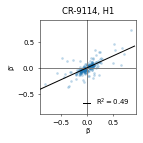

In [30]:
# compare coefficients
regress = st.linregress(coefs_H1[both_sig],coefs_H1_xform[both_sig])
print(regress.slope,regress.intercept)
print(regress.rvalue**2)
        
minval = min([min(coefs_H1[both_sig]),min(coefs_H1_xform[both_sig])])
maxval = max([max(coefs_H1[both_sig]),max(coefs_H1_xform[both_sig])])

    
xvals = np.arange(minval-0.1,maxval+0.1,0.1)

plt.figure(figsize=(2,2))
plt.scatter(x=coefs_H1[both_sig],y=coefs_H1_xform[both_sig],alpha=0.2,s=3)
plt.plot([0,0],[minval-0.1,maxval+0.1],color='grey',linewidth=1)
plt.plot([minval-0.1,maxval+0.1],[0,0],color='grey',linewidth=1)

plt.plot(xvals,regress.slope*xvals+regress.intercept,'k-',label=f"$R^2={(regress.rvalue**2):.2f}$",linewidth=1)
plt.legend(loc='lower right',handlelength=1,frameon=False)
plt.xlim([minval-0.1,maxval+0.1])
plt.ylim([minval-0.1,maxval+0.1])
plt.xlabel(r"$\beta$",labelpad=0)
plt.ylabel(r"$\beta\prime$",labelpad=0)
plt.title('CR-9114, H1')
plt.tight_layout()
plt.savefig('images/9114_H1_'+function+'_coef_regress.pdf')
plt.show()

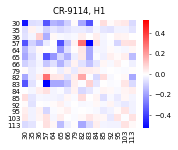

In [32]:
# heatmap of differences between coefs
deltas_H1 = coefs_H1-coefs_H1_xform
deltas_H1_heatmap = np.zeros((num_mutations_H1,num_mutations_H1))

for i in range(1,len(deltas_H1)):

    muts_involved = [int(x)-1 for x in names_H1[i].split(',')]
    if len(muts_involved) == 1:
        deltas_H1_heatmap[muts_involved[0],muts_involved[0]] += deltas_H1[i]
    if len(muts_involved) >= 2:
        for j in range(len(muts_involved)):
            for k in range(j+1,len(muts_involved)):
                deltas_H1_heatmap[muts_involved[k],muts_involved[j]] += deltas_H1[i]
                deltas_H1_heatmap[muts_involved[j],muts_involved[k]] += deltas_H1[i]
                
norm_val = max(np.abs(np.nanmin(deltas_H1_heatmap)),np.abs(np.nanmax(deltas_H1_heatmap)))

fig,ax = plt.subplots(figsize=(2.5,2.1))
sns.heatmap(deltas_H1_heatmap,cmap='bwr',vmin=-1*norm_val,vmax=norm_val) #,norm=log_norm,cmap='rocket') #,cbar_kws={"ticks": cbar_ticks})

plt.xticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='0')
ax.tick_params(length=0,pad=1)
plt.title('CR-9114, H1')

plt.tight_layout()
plt.savefig('images/9114_H1_'+function+str(num_func_params)+'_coef_deltas.pdf')
plt.show()


## H3

In [33]:
# read model coefficients

coefs_H3 = np.zeros(total_params_H3+1)
names_H3 = []
sig_H3 = np.full((total_params_H3+1),0)
cis_H3 = np.zeros((total_params_H3+1,2))

with open('../../../CR9114/Epistasis_linear_models/model_coefs/H3_'+str(order_H3)+'order_'+ep_type+'.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2 = float(next(coef_reader)[-1])
    header = next(coef_reader)
    #print(header)
    for i in range(total_params_H3+1):
        row = next(coef_reader)
        names_H3.append(row[0])
        coefs_H3[i] = float(row[1])
        if i >= 1:
            cis_H3[i,0] = float(row[4])
            cis_H3[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_H3[i] = 1
    readfile.close()
            

num_sig = len(np.nonzero(sig_H3 == 1)[0])
print('No transformation: ',len(coefs_H3),num_sig)

coefs_H3_xform = np.zeros(total_params_H3+1)
names_H3_xform = []
sig_H3_xform = np.full((total_params_H3+1),0)
cis_H3_xform = np.zeros((total_params_H3+1,2))

with open('model_coefs/globalep_9114_H3_'+function+str(num_func_params)+'_'+str(order_H3)+'order_'+ep_type+'.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    for i in range(num_func_params+2):
        next(coef_reader)
    num_params_xform = int(next(coef_reader)[-1])
    r2_xform = float(next(coef_reader)[-1])
    header = next(coef_reader)
    #print(header)
    for i in range(total_params_H3+1):
        row = next(coef_reader)
        names_H3_xform.append(row[0])
        coefs_H3_xform[i] = float(row[1])
        if i >= 1:
            cis_H3_xform[i,0] = float(row[4])
            cis_H3_xform[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_H3_xform[i] = 1
    readfile.close()
            

num_sig_xform = len(np.nonzero(sig_H3_xform == 1)[0])
print('Transformation: ',len(coefs_H3_xform),num_sig_xform)

both_sig = np.nonzero((sig_H3 == 1) | (sig_H3_xform ==1))[0]
print(len(both_sig))


No transformation:  1093 73
Transformation:  1093 97
109
61
Percent overlap of sig coefs:  0.8356164383561644 0.6288659793814433


1.244788873836001 -0.007479427403151859
0.8923423559072544
5,6,7 -0.2425477164302703 5,6,7 0.13800226471802235
1,2,6,7 0.0017003361866195776 1,2,6,7 -0.09605612726442128


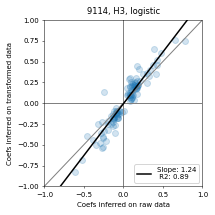

In [35]:
# compare coefficients
regress = st.linregress(coefs_H3[both_sig],coefs_H3_xform[both_sig])
print(regress.slope,regress.intercept)
print(regress.rvalue**2)

for i in range(len(both_sig)):
    if coefs_H3[both_sig[i]]*coefs_H3_xform[both_sig[i]] < 0:
        print(names_H3[both_sig[i]],coefs_H3[both_sig[i]],names_H3_xform[both_sig[i]],coefs_H3_xform[both_sig[i]])

        
xmin = -1
xmax = 1
xvals = np.arange(xmin,xmax,0.1)

plt.figure(figsize=(3,3))
plt.scatter(x=coefs_H3[both_sig],y=coefs_H3_xform[both_sig],alpha=0.2)
plt.plot([xmin,xmax],[xmin,xmax],color='grey',linewidth=1)
plt.plot([0,0],[xmin,xmax],color='grey',linewidth=1)
plt.plot([xmin,xmax],[0,0],color='grey',linewidth=1)

plt.plot(xvals,regress.slope*xvals+regress.intercept,'k-',label=f'Slope: {regress.slope:.2f}\n R2: {(regress.rvalue**2):.2f}')
plt.legend(loc='lower right')
plt.xlim([xmin,xmax])
plt.ylim([xmin,xmax])
plt.xlabel('Coefs inferred on raw data')
plt.ylabel('Coefs inferred on transformed data')
plt.title('9114, H3, '+function)
plt.tight_layout()
plt.savefig('images/9114_H3_'+function+'_coef_regress.pdf')
plt.show()

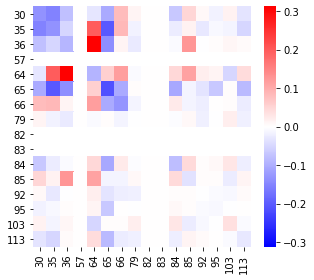

In [28]:
# heatmap of differences between coefs
deltas_H3 = coefs_H3-coefs_H3_xform
deltas_H3_heatmap = np.zeros((num_mutations_H1,num_mutations_H1))

for mut in [4,9,10]:
    for i in range(num_mutations_H1):
        deltas_H3_heatmap[mut-1,i] = np.nan
        deltas_H3_heatmap[mut-1,i] = np.nan

for i in range(1,len(deltas_H3)):

    muts_involved = [int(x)-1 for x in names_H3[i].split(',')]
    if len(muts_involved) == 1:
        deltas_H3_heatmap[muts_involved[0],muts_involved[0]] += deltas_H3[i]
    if len(muts_involved) >= 2:
        for j in range(len(muts_involved)):
            for k in range(j+1,len(muts_involved)):
                deltas_H3_heatmap[muts_involved[k],muts_involved[j]] += deltas_H3[i]
                deltas_H3_heatmap[muts_involved[j],muts_involved[k]] += deltas_H3[i]
                
norm_val = max(np.abs(np.nanmin(deltas_H3_heatmap)),np.abs(np.nanmax(deltas_H3_heatmap)))

plt.figure(figsize=(4.5,4))
sns.heatmap(deltas_H3_heatmap,cmap='bwr',vmin=-1*norm_val,vmax=norm_val) #,norm=log_norm,cmap='rocket') #,cbar_kws={"ticks": cbar_ticks})

plt.xticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='0')
plt.tight_layout()
plt.savefig('figures/9114_H3_'+function+str(num_func_params)+'_coef_deltas.pdf')
plt.show()